# Task 2: Clustering

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Customer Profile model

In [309]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,E,Monetary,Recency,T,Frequency
CustomerID,,,,,,,,
12747.0,6.674561,3.367296,4.941642,1.451864,5.467406,5.762051,5.831882,2.079442
12748.0,9.485925,7.273786,7.108244,1.888435,5.229524,5.814131,5.828946,4.553877
12749.0,7.110696,4.787492,6.439350,1.532598,6.259295,5.746203,5.817111,1.098612
12820.0,6.513230,3.988984,5.497168,1.393521,5.525665,5.641907,5.789960,1.098612
12822.0,6.122493,3.610918,5.913503,1.413603,5.049728,2.833213,4.477337,0.000000
...,...,...,...,...,...,...,...,...
18272.0,7.367709,4.477337,5.863631,1.550851,6.203733,5.407172,5.420535,1.609438
18273.0,3.688879,0.000000,2.995732,-2.302585,3.931826,4.672829,5.552960,0.000000
18282.0,3.931826,2.079442,3.258097,1.047319,4.107425,4.442651,5.707110,0.000000


In [310]:
customer_profile = customer_profile.to_numpy()

## Standardization \& Dimensionality Reduction

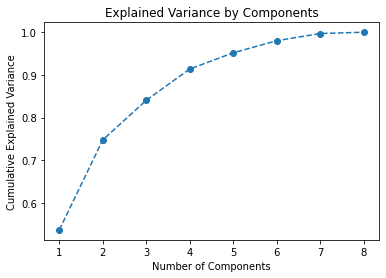

In [311]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
std_customer_profile = scaler.fit_transform(customer_profile)

pca = PCA()
pca.fit(std_customer_profile)

plt.plot(range(1, customer_profile.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 2 components.

In [312]:
pca = PCA(n_components=2)
pca_customer_profile = pca.fit_transform(std_customer_profile)

In [313]:
from sklearn.metrics import silhouette_score

## K-Means

In [286]:
from sklearn.cluster import KMeans

In [287]:
for k in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_customer_profile)
    print("For k =", k, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For k = 2 the silhouette score is: 0.40845663431509427
For k = 3 the silhouette score is: 0.34866176031100815
For k = 4 the silhouette score is: 0.3711949399779862
For k = 5 the silhouette score is: 0.3313184845296722
For k = 6 the silhouette score is: 0.339490685094876
For k = 7 the silhouette score is: 0.3401644632642818
For k = 8 the silhouette score is: 0.331007961620649
For k = 9 the silhouette score is: 0.3283905232125472


The best silhouette score obtained is when the number of clusters is 2.

In [289]:
kmeans = KMeans(init='k-means++', n_clusters=2)
clusters_customers = kmeans.fit_predict(pca_customer_profile)

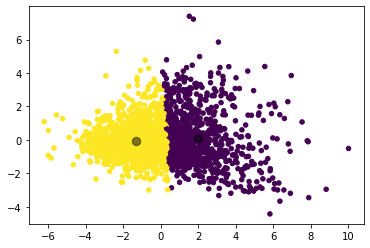

In [290]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

What's the number of customers in each cluster?

In [291]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,1,0
CustomersNb,1375,902


For comparison, if we run only the k-means algorithm without the PCA step, the result would be the following:

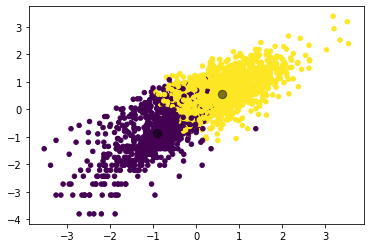

In [292]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

## Fuzzy C-Means

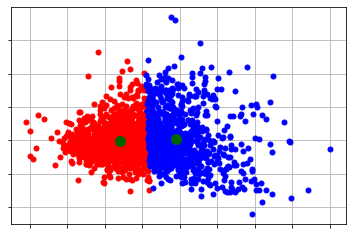

In [369]:
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.fcm import fcm

# initialize
initial_centers = kmeans_plusplus_initializer(pca_customer_profile, 2, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(pca_customer_profile, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, pca_customer_profile, markersize=10)
visualizer.append_cluster(centers, markersize=20)
visualizer.show();

## DBSCAN

We can calculate the distance from each point to its closest neighbour using the K-nearest neighbors. The point itself is included in *n_neighbors*. The Knn method returns two arrays, one which contains the distance to the closest *n_neighbors* points and the other which contains the index for each of those points. The optimal value for *eps* will be found at the point of maximum curvature.

In [229]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

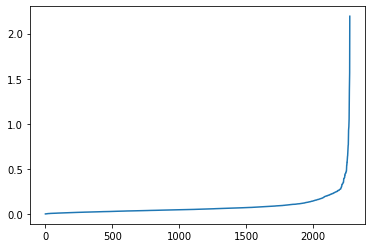

In [344]:
knn = NearestNeighbors(n_neighbors=10)
nbrs = knn.fit(pca_customer_profile)
distances, indices = nbrs.kneighbors(pca_customer_profile)
distances = np.sort(distances, axis=0)[:,1]
plt.plot(distances);

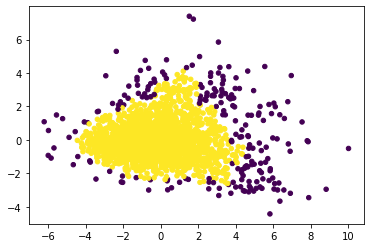

In [359]:
dbscan = DBSCAN(eps=0.4, min_samples=9)
clusters_customers = dbscan.fit_predict(pca_customer_profile)
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [360]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,-1
CustomersNb,2067,210


For comparison, if we run only the DBSCAN algorithm without the PCA step, the result would be the following:

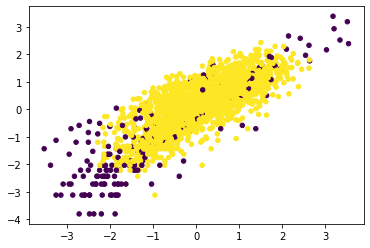

In [361]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

## Agglomerative Clustering

In [235]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion:

- *Ward* minimizes the euclidean distance of the clusters being merged (is the hierarchical analogue of K-means, so it can be used to initialize it)
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters
- *single* or *maximum linkage* uses the minimum of the distances between all observations of the two sets
    - strength: can handle non-elliptical shapes
    - limitations: sensitive to noise and outliers
- *complete* or *maximum linkage* uses the maximum distances between all observations of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: tends to break large clusters, biased towards globular clusters
- *average* linkage is a compromise between *single* and *complete* linkage by using the average of the distances of each observation of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters

### Ward Linkage

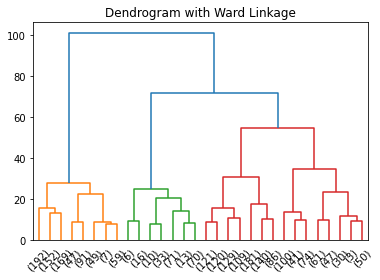

In [394]:
plt.title('Dendrogram with Ward Linkage')
ward_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='ward')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 3 for the given data.

In [395]:
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

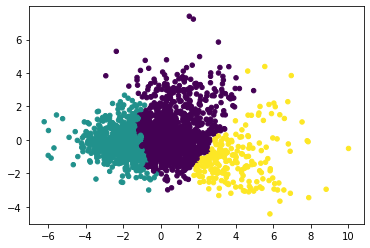

In [396]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [397]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1,2
CustomersNb,1292,766,219


For comparison, if we run only the agglomerative clustering algorithm with the Ward linkage without the PCA step, the result would be the following:

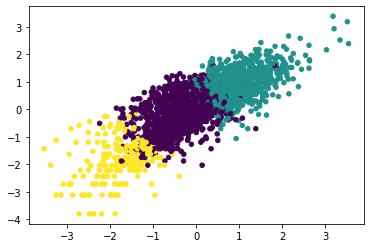

In [398]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

### Single Linkage

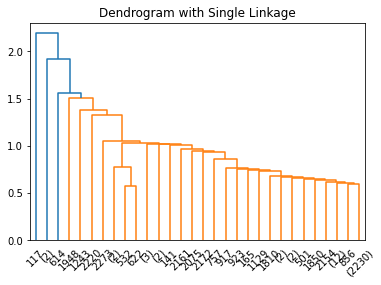

In [399]:
plt.title('Dendrogram with Single Linkage') 
min_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='single')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 1 for the given data.

In [400]:
agglomerative = AgglomerativeClustering(n_clusters=1, linkage='single')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

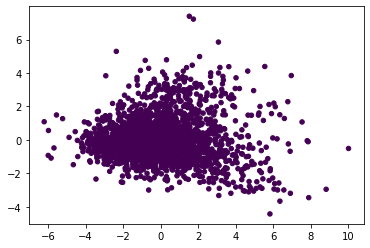

In [401]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [402]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0
CustomersNb,2277


For comparison, if we run only the agglomerative clustering algorithm with the single linkage without the PCA step, the result would be the following:

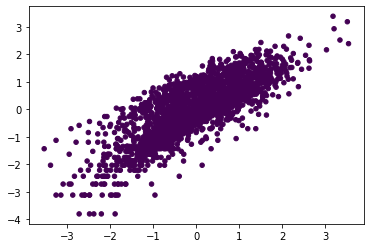

In [403]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

### Complete Linkage

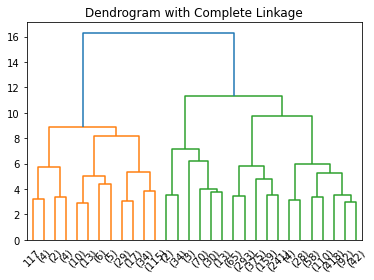

In [404]:
plt.title('Dendrogram with Complete Linkage') 
max_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='complete')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 2 for the given data.

In [405]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='complete')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

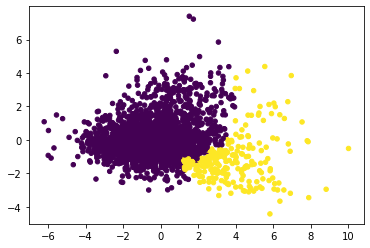

In [406]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [407]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,2037,240


For comparison, if we run only the agglomerative clustering algorithm with the complete linkage without the PCA step, the result would be the following:

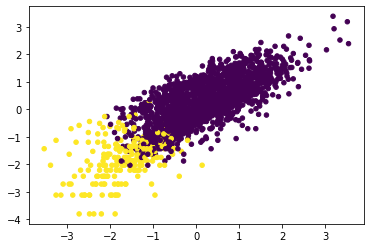

In [408]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

### Average Linkage

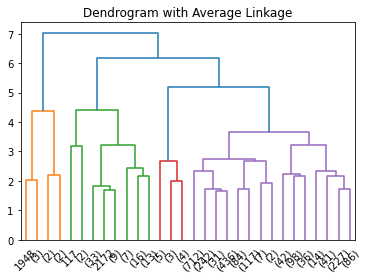

In [409]:
plt.title('Dendrogram with Average Linkage') 
avg_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='average')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 4 for the given data.

In [410]:
agglomerative = AgglomerativeClustering(n_clusters=4, linkage='average')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

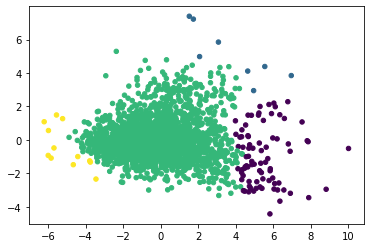

In [411]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [412]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,2,0,3,1
CustomersNb,2175,82,12,8


For comparison, if we run only the agglomerative clustering algorithm with the average linkage without the PCA step, the result would be the following:

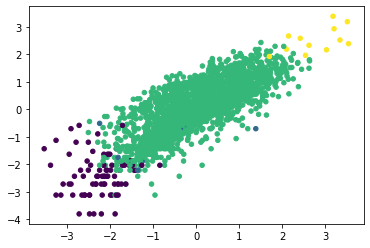

In [393]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);